# 1 - Title

Project Title : Forecast Produk Terlaku dengan Time Series Analysis

Description : Project ini melakukan forecast dari produk yang paling banyak terjual dengan analisis time series.

# 2 - Introduction

Nama  : Mukhlish Rasyidi

Batch : RMT - 018

Dataset : sample_dataset_timeseries_noarea.csv

Objective : 

Dalam suatu industri ada dua divisi yang memiliki peran saling bergantungan, yaitu bagian Marketing dan Product Planning Inventory Control (PPIC). Team marketing akan memberikan input berupa forecasting kebutuhan stock product yang akan mereka jual berdasarkan data produk yang sudah laku dan target untuk bulan bulan berikutnya. Sedangkan tim PPIC akan berusaha semaksimal mungkin memenuhi permintaan dari tim marketing. 

Tantangan yang cukup berat bagi tim marketing adalah melakukan forecast dengan tepat, berapa banyak produk yang harus diproduksi oleh PPIC dan jenis product apa yang paling laku dipasaran. Hal ini karena setiap produk memiliki cost, sehingga ketika salah forecast dan barang tidak laku tentunya akan membuat kerugian untuk perusahaan. Begitupun sebaliknya, ketika seharusnya masih bisa menjual lebih banyak produk ke konsumen namun produknya sudah habis menyebabkan kemungkinan konsumen menggunakan produk lain ( competitor), hal ini pun memberikan kerugian bagi industri.

Selain terkait produk tidak laku / kehabisan produk, tim PPIC juga memiliki kendala tidak bisa dengan secepat kilat memproduksi produk sesuai dengan pertmintaan tim marketing.  Mereka perlu proses yang cukup panjang dari mulai penyedian bahan baku hingga produk siap jadi. Apalagi jika Industri tersebut memiliki keterbatasan jumlah lini produksi yang bisa dibuat, mereka harus bergantian untuk memproduksi produk a, dan setelah selesai baru ke produk B.

Dalam melakukan forecasting bisa dilakukan dengan dua pendekatan yaitu secara kualitatif dan kuantitatif, pendekatan kualitatif lebih seperti melakukan survey langsung ke pasar untuk mengetahui berapa besar kemungkinan produk akan dibeli konsumen namun memiliki kendala perlu biaya besar dan juga memakan waktu lebih lama. Sedangkan pendekatan kuantitatif lebih menggunakan berdasarkan data- data penjualan sebelumnya dianalisis dan dicari patternnya, kemudian dijadikan dasar forecast ( Time series).

Berdasarkan permasalahan tersebut, objective saya adalah membuat model machine learning yang bisa melakukan forecasting jumlah produk yang akan terjual dibulan yang akan datang, model yang dicari adalah model yang memiliki nilai  metric evaluasi  MAE, dan MAPE yang paling kecil. 


# 3 - External Link

1. Link Deployment : [huggingface](https://huggingface.co/spaces/mukhlishr/final-project)

2. Link Presentation : [Slide Presentation](https://docs.google.com/presentation/d/17DeAKgjHVGKq47YxfMUXWOG6cRzMLDUWQlv5XdXdSsk/edit?usp=sharing)

# 4 - Working Area

## 4.1 -  Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

## 4.2 -  Data loading

In [2]:
# Read data CSV
df = pd.read_csv('https://raw.githubusercontent.com/mukhlishr/rasyidi/main/sample_dataset_timeseries_noarea.csv')

In [3]:
# Duplicate dataset
df_copy = df.copy()

In [4]:
# Show the dataset
df

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920


In [5]:
# Check over all dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


Dari pengamatan secara keseluruhan, dataset terdiri dari 5 columns dan semua columns tidak ada yang missing values.

## 4.3 - Exploratory Data (EDA)

Berdasarkan data loading terlihat untuk tanggal nya masih menggunakan tanggal spesifik sehingga akan disederhanakan menjadi tahun, bulan, dan tanggal yang sama. Tanggal yang digunakan akan di standarkan menjadi tanggal 1 untuk setiap bulannya. Column tanggal yang akan ditransform adalah week_end_date, tanggal akhir saat produk terjual.

In [6]:
# Create column year, month, date
df['year'] = pd.DatetimeIndex(df['week_end_date']).year
df['month'] = pd.DatetimeIndex(df['week_end_date']).month
df['date'] = df.apply(lambda x: datetime(x[5], x[6], 1), axis=1)
df

,week_number,week_start_date,week_end_date,product_item,quantity,year,month,date
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,2022,1,2022-01-01
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,2022,1,2022-01-01
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,2022,1,2022-01-01
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,2022,1,2022-01-01
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,2022,1,2022-01-01
...,...,...,...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907,2023,4,2023-04-01
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81,2023,4,2023-04-01
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16,2023,4,2023-04-01
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920,2023,4,2023-04-01


In [7]:
df['quantity'].sum()

327878782

In [8]:
# Check unique product and top seller
top_seller = df.groupby(['product_item'])['quantity'].sum().sort_values( ascending = False)
top_seller

product_item
2949ca4cfbf13969bccfbb9817f2526a    18206376
2db7ed9bd7573aec037aac59237cb3dd     9122007
160eb16a7369a645ec75caa3f14543d4     6771207
229a936943f7da9feea525f1a48d1d03     6658518
0f9d1e065ad64ecd7237084107a4bfbd     4202082
                                      ...   
3619fde2d22f364f14a595f2c7d95eb0           2
d79c7a64e815ebb411b976fc2444f750           2
3db6960af3e714e64aa08ee193515a62           2
41cdee563778c1530de2b9b4480f6d4e           2
91c30a9df505d481487e1d5099cc57dd           2
Name: quantity, Length: 2309, dtype: int64

Terlihat dari product item terdapat 2309 jenis produk. Produk yang paling banyak terjual ada pada product item dengan kode '2949ca4cfbf13969bccfbb9817f2526a' dengan total penjualan 18.206.376 . 

Sedangkan product item tersedikit total penjualannya yaitu 2 produk dan ada lebih dari 5 jenis produk yang total penjualannya 2.

In [9]:
# Create dataframe date as index
all = df.groupby(['date'])['quantity'].sum()
all = pd.DataFrame(all, columns=('date','quantity'))
all.dropna(axis=1,inplace=True)
all

,quantity
date,
2022-01-01,17080649
2022-02-01,16458214
2022-03-01,18215788
2022-04-01,19864159
2022-05-01,24090999
2022-06-01,23546948
2022-07-01,28239962
2022-08-01,23339815
2022-09-01,22248136


Berdasarkan pengamatan dari bulan dengan jumlah quantity terlihat untuk di akhir periode dataset yaitu bulan 2023-04-01 jumlah penjualan paling banyak terkoreksi hingga 8 juta penjualan dibandingkan bulan sebelumnya. Perlu dicek lebih mendalam, bisa jadi kemungkinan untuk bulan 4 tahun 2023 masih belum penuh pengumpulan data, sehingga terlihat sangat terkoreksi jumlah penjualannya.

In [10]:
# Check month 04-2023 
df[df['date']=='2023-04-01']

,week_number,week_start_date,week_end_date,product_item,quantity,year,month,date
99718,2023-13,2023-03-27,2023-04-02,0073377087c7ddace313ff829cd7b0b3,5,2023,4,2023-04-01
99719,2023-13,2023-03-27,2023-04-02,0098d23d332c193a07eabaf0f703d4e5,3523,2023,4,2023-04-01
99720,2023-13,2023-03-27,2023-04-02,009e12e8fd2ef0b77047206e939fc6b9,574,2023,4,2023-04-01
99721,2023-13,2023-03-27,2023-04-02,00b21b77bbe70ca3b33125402cfaa7b4,68,2023,4,2023-04-01
99722,2023-13,2023-03-27,2023-04-02,00ebd78145a6c6dac6d509632c589cab,161,2023,4,2023-04-01
...,...,...,...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907,2023,4,2023-04-01
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81,2023,4,2023-04-01
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16,2023,4,2023-04-01
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920,2023,4,2023-04-01


Berdasarkan pengamatan untuk periode penjualan di bulan 4 tahun 2023, data yang terkumpul baru sampai dengan tanggal 9. Dengan kondisi ini maka untuk data bulan 04-2023 harus di drop karena akan menyebabkan bias bila digunakan sebagai data penjualan.

In [11]:
# drop month 04-2023
all.drop(['2023-04-01'], inplace=True)
all

,quantity
date,
2022-01-01,17080649
2022-02-01,16458214
2022-03-01,18215788
2022-04-01,19864159
2022-05-01,24090999
2022-06-01,23546948
2022-07-01,28239962
2022-08-01,23339815
2022-09-01,22248136


<Axes: xlabel='date', ylabel='quantity'>

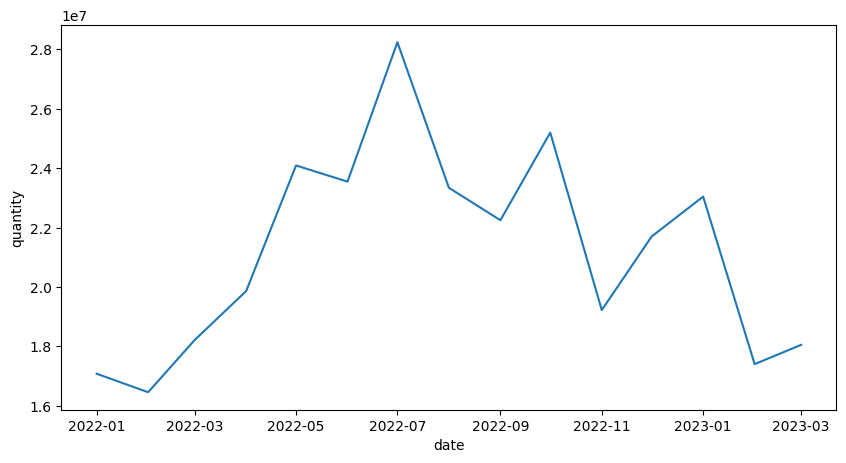

In [12]:
# Check Graphic all
plt.figure(figsize=(10,5))
sns.lineplot(data=all, x=all.index,y=all.quantity)

Bila melihat dari grafik jumlah produk terjual perbulannya, tidak terlihat adanya tren. Ada kemungkinan polanya seasonal namun tidak bisa dipastikan dengan melihat dari grafiknya, karena datanya baru 1 tahun sehingga tidak bisa diketahui secara pasti apakah seasonal atau tidak. 

Untuk melakukan proses analisis time series, salah satu syaratnya adalah datasetnya stationer atau harus di stationerkan terlebih dahulu sebelum modeling. Akan dilakukan pengecekan stationer dataset.

In [13]:
# Function check stationary
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [14]:
# Check stationary all
check_stationarity(all['quantity'])

ADF Statistic: -2.126781
p-value: 0.233883
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691
Non-stationary


Berdasarkan pengecekan apakah datasetnya stationary atau tidak menggunakan adfuller, terlihat nilai statisticnya lebih besar dibanding nilai critic value. hal ini menunjukan data nya tidak stationary, dan dari nilai p value juga menunjukan lebih besar dari 0.05 yang berarti menerima h0, h0 disini adalah non-stationary.

Sesuai dengan objective diawal, yaitu focus ke satu produk untuk diforecast, maka dalam project ini saya akan memforecast untuk produk yang paling banyak terjual (terlaku). Karena bila memforecast secara keseluruhan, tidak dapat diketahui berapa banyak jumlah permasing masing product item yang laku dan tidak diketahui juga mana produk item yang mengalami penurunan.

In [15]:
# Best seller product
best_seller = df[df['product_item']=='2949ca4cfbf13969bccfbb9817f2526a']
best_seller

,week_number,week_start_date,week_end_date,product_item,quantity,year,month,date
90,2021-52,2021-12-27,2022-01-02,2949ca4cfbf13969bccfbb9817f2526a,56851,2022,1,2022-01-01
712,2022-01,2022-01-03,2022-01-09,2949ca4cfbf13969bccfbb9817f2526a,269285,2022,1,2022-01-01
2205,2022-02,2022-01-10,2022-01-16,2949ca4cfbf13969bccfbb9817f2526a,196277,2022,1,2022-01-01
3683,2022-03,2022-01-17,2022-01-23,2949ca4cfbf13969bccfbb9817f2526a,210053,2022,1,2022-01-01
5162,2022-04,2022-01-24,2022-01-30,2949ca4cfbf13969bccfbb9817f2526a,284402,2022,1,2022-01-01
...,...,...,...,...,...,...,...,...
95509,2023-10,2023-03-06,2023-03-12,2949ca4cfbf13969bccfbb9817f2526a,233312,2023,3,2023-03-01
97024,2023-11,2023-03-13,2023-03-19,2949ca4cfbf13969bccfbb9817f2526a,225327,2023,3,2023-03-01
98519,2023-12,2023-03-20,2023-03-26,2949ca4cfbf13969bccfbb9817f2526a,217546,2023,3,2023-03-01
100004,2023-13,2023-03-27,2023-04-02,2949ca4cfbf13969bccfbb9817f2526a,360227,2023,4,2023-04-01


In [16]:
# Create dataframe best seller
best_seller = best_seller.groupby(['date'])['quantity'].sum()
best_seller = pd.DataFrame(best_seller, columns=('date','quantity'))
best_seller.dropna(axis=1,inplace=True)
best_seller

,quantity
date,
2022-01-01,1016868
2022-02-01,803638
2022-03-01,1423588
2022-04-01,848460
2022-05-01,817581
2022-06-01,1921280
2022-07-01,1426270
2022-08-01,1134174
2022-09-01,1576630


In [17]:
# Best seller after drop month of April 2023
best_seller.drop(['2023-04-01'], inplace=True)
best_seller

,quantity
date,
2022-01-01,1016868
2022-02-01,803638
2022-03-01,1423588
2022-04-01,848460
2022-05-01,817581
2022-06-01,1921280
2022-07-01,1426270
2022-08-01,1134174
2022-09-01,1576630


<Axes: xlabel='date', ylabel='quantity'>

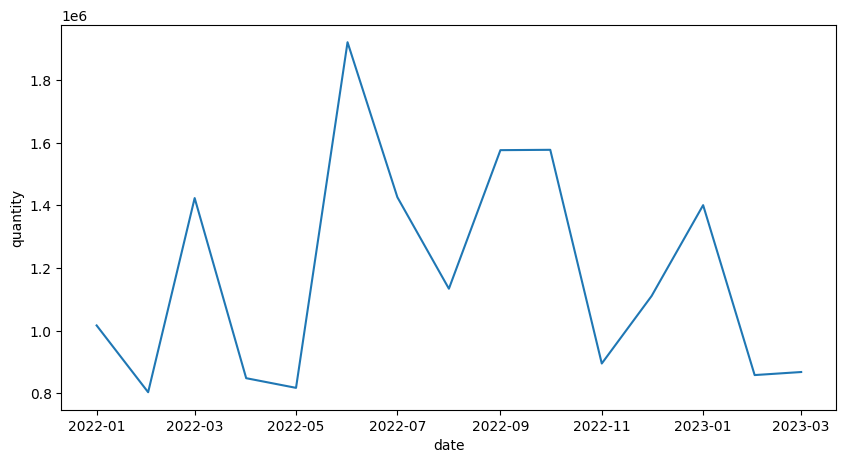

In [18]:
# Check graphic bestseller
plt.figure(figsize=(10,5))
sns.lineplot(data=best_seller, x=best_seller.index,y=best_seller.quantity)

Berdasarkan graphik plot terlihat untuk best_seller juga tidak memiliki trend dari penjualan perbulannya. Penjualannya tidak selalu mengalami kenaikan atau pernurunan. Untuk pola seasonal juga tidak bisa terlihat karena tidak ada pola yang jelas pada bulan apa penjualan naik dan sampai puncak penjualan tertinggi, dan pada bulan apa akan turun. 

Untuk Stationer perlu dicek juga menggunakan adfuller function.

In [19]:
# Check stationary best seller
check_stationarity(best_seller['quantity'])

ADF Statistic: -2.511533
p-value: 0.112693
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
Non-stationary


Berdasarkan pengecekan stationary dengan adfuller terlihat data best seller juga termasuk non stationary

Dari hasil proses EDA dapat diketahui sebagai berikut:
1. Tanggal terakhir produk terjual dimulai dari periode tanggal 02-01-2022 s/d 09-04-2023.
2. Jumlah product item ada 2.309 Produk.
3. Produk item terlaku dengan total penjualan produk sebanyak 18.206.376
4. Produk item tersedikit dengan total penjualan hanya 2 produk.
5. Berdasarkan pengecekan secara grafik, untuk lineplot penjualan all maupun best seller tidak ada pattern tren positif atau negatif dan untuk seasonal belum dapat dipastikan ada atau tidak. 
6. Berdasarkan pengecekan dengan Augmenter Dickey Fuller Test (adfuller), untuk data all dan best seller semuanya tidak stasioner. Dan perlu dilakukan differencing sebelum masuk dalam ke pemodelan.



## 4.4 - Feature Engineering

### 4.4.1 - Differencing 

Pada bagian ini dilakukan differencing karena diketahui data tidak stasioner, dimana sarat untuk melakukan analisis time series data harus dalam kondisi stasioner. Teknik yang digunakan yaitu differencing dengan rumus  quantity(n+1) - quantity(n), Quantity di bulan berikutnya dikurangin dengan quantity bulan sekarang. 

In [20]:
# Check stationarity differencing
check_stationarity(best_seller['quantity'].diff().dropna())

ADF Statistic: -12.096956
p-value: 0.000000
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Stationary


Berdasarkan pengecekan dengan adfuller, data best seller sudah menjadi stationary dengan satu kali differencing.

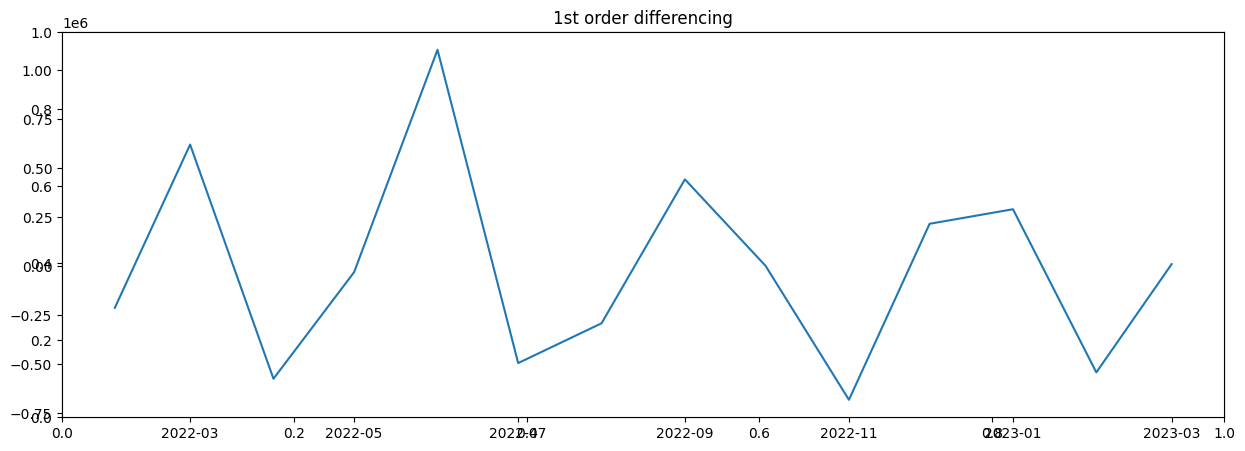

In [21]:
# Plot data differencing
fig,ax=plt.subplots(figsize=(15,5))
ax1= fig.add_subplot()
ax1.set_title('1st order differencing')
ax1.plot(best_seller['quantity'].diff().dropna())

Terlihat dari grafik datanya sudah stationer.

### 4.4.2 - Plot ACF & PCF

Untuk melakukan forecasting time series secara kuantitatif ada dua kondisi yang harus diperhatikan, yang pertama adalah pengaruh jumlah penjualan dibulan sebelumnya terhadap penjualan bulan berikutnya, atau secara bahasa sistemnya disebut dengan auto correlation Function. 

Yang ke dua adalah korelasi partial atau korelasi bersyarat dengan asumsi memperhitungkan penyesuaian dari penjumlahan bulan sebelumnya. Untuk mengetahui nilai ACF dan PCF adalah dengan bantuan plot ACF dan plot PCF, dicari pada lag ke berapa kondisi cutting of.

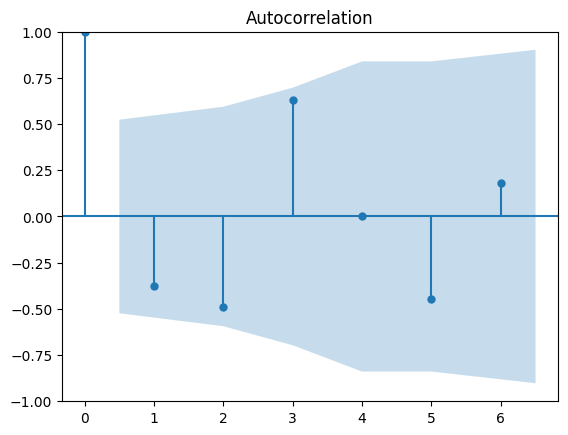

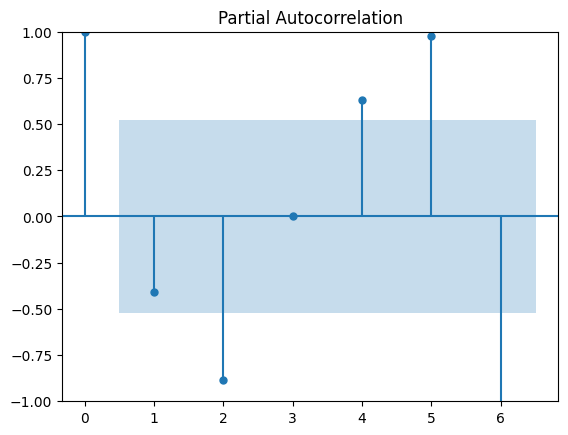

In [22]:
plot_acf(best_seller['quantity'].diff().dropna(),lags=6)
plot_pacf(best_seller['quantity'].diff().dropna(),lags=6)
plt.show()

Terlihat untuk plot ACF cut off pada lag = 0, Sedangkan untuk plot PCF pada lag = 0;2;5

### 4.4.3 - Splitting Dataset

Dilakukan splitting untuk train dan test, dimana train 80 % dan test 20%.

In [23]:
# Splitting Dataset

train=best_seller[:12]
test=best_seller[12:]

In [24]:
# Show train
train

,quantity
date,
2022-01-01,1016868
2022-02-01,803638
2022-03-01,1423588
2022-04-01,848460
2022-05-01,817581
2022-06-01,1921280
2022-07-01,1426270
2022-08-01,1134174
2022-09-01,1576630


In [25]:
# Show test
test

,quantity
date,
2023-01-01,1401010
2023-02-01,858394
2023-03-01,868148


## 4.5 - Arima

Model pertama yang digunakan adalah dengan algoritma ARIMA (Auto Regresi Integrated Moving Average), untuk dataset dengan kondisi tidak stasioner maka untuk analisisnya harus menggunakan ARIMA dan SARIMA dengan order (p,d,q). Dimana nilai p adalah nilai lag cutting of PACF yang sudah distasionerkan, d sama dengan nilai berapa kali dilakukan differencing, dan nilai q untuk nilai ACF.

Arima memiliki kelebihan dalam memforecast dengan baik untuk data set non stasioner dan tidak meiliki pola seasonal, namun kekurangannya tidak bisa untuk forecast dalam jangka panjang. hanya baik untuk jangka pendek sehingga perlu dilakukan update secara terus menerus agar hasil forecastnya selalu bagus.

### 4.5.1 - Model Definition

In [26]:
# Model definition
arima=ARIMA(endog=train, order=(5,1,0))

### 4.5.2 - Model Training

In [27]:

#arima=ARIMA(train,order=(5,1,0))
mod_train=arima.fit()
mod_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                   12
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -189.059
Date:                Sun, 16 Apr 2023   AIC                            390.118
Time:                        02:21:22   BIC                            392.506
Sample:                    01-01-2022   HQIC                           388.613
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8464      0.049    -17.359      0.000      -0.942      -0.751
ar.L2         -0.4841      0.041    -11.820      0.000      -0.564      -0.404
ar.L3          0.3740      0.077      4.857      0.000       0.223       0.525
ar.L4          0.6902      0.049     14.195      0.000       0.595       0.786
ar.L5          0.6642      0.050     13.370      0.000       0.567       0.762
sigma2        1.5e+10   1.06e-12   1.41e+22      0.000     1.5e+10     1.5e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.55   Prob(JB):                         0.95
Heteroskedasticity (H):               1.05   Skew:                             0.21
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+37. Standard errors may be unstable.
"""

In [28]:
y_pred_train=mod_train.predict()
y_pred_train=pd.DataFrame(y_pred_train)
y_pred_train.columns=['quantity_predict']

In [29]:
y_pred_train

,quantity_predict
2022-01-01,0.000000e+00
2022-02-01,5.591934e+05
2022-03-01,4.385200e+05
2022-04-01,1.030121e+06
2022-05-01,1.199185e+06
2022-06-01,1.882273e+06
2022-07-01,1.073261e+06
2022-08-01,1.314149e+06
2022-09-01,1.630518e+06
2022-10-01,1.899735e+06


### 4.5.3 - Model Evaluation

Pada bagian evaluasi dilakuakn prediksi terhadap tes dan kemudian dibandingkan dengan nilai aslinya. untuk mengatahui seberapa baik atau buruk digunakan metric evaluase Mean Absolute Error (MAE) dan Mean Absolute Percentage Error (MAPE).

Secara simple MAE adalah mengetahui berapa banyak selisih kurang atau lebih dari angka yang diprediksi. Semakin kecil selisih semakin baik. Sedangkan MAPE selisih tersebut sudah dijadikan percent, semakin kecil percent MAPE semakin baik.

In [72]:
y_pred_test=mod_train.predict(start='2023-01-01',end='2023-03-01')
y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test.columns=['quantity_predict']

In [73]:
y_pred_test

,quantity_predict
2023-01-01,1.370631e+06
2023-02-01,1.085906e+06
2023-03-01,8.115968e+05


In [74]:
act_vs_pred=pd.concat([test,y_pred_test], axis=1)
act_vs_pred

,quantity,quantity_predict
2023-01-01,1401010,1.370631e+06
2023-02-01,858394,1.085906e+06
2023-03-01,868148,8.115968e+05


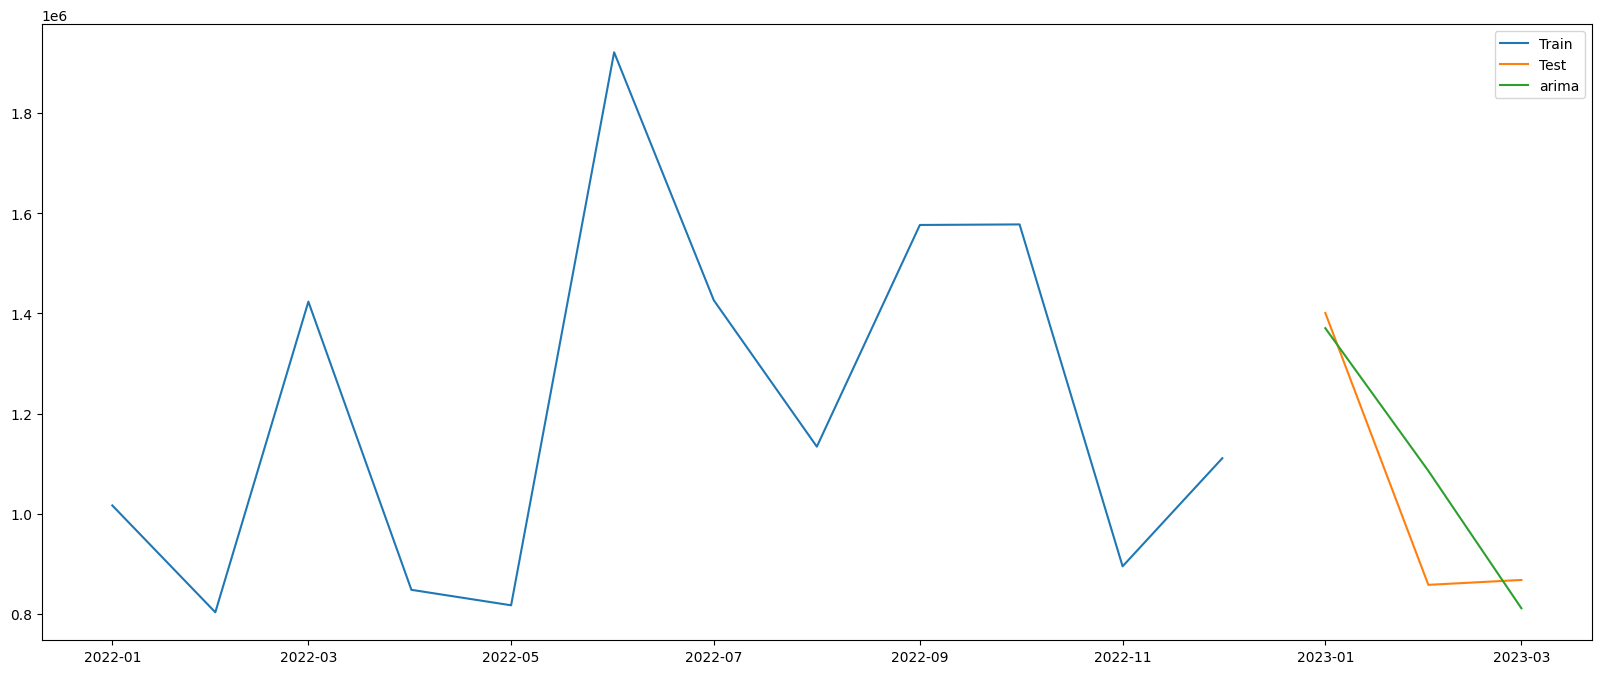

In [75]:
plt.figure(figsize=(20,8))
plt.plot( train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_pred_test['quantity_predict'], label='arima')
plt.legend(loc='best')
plt.show()

Dari hasil plot predict test dengan real test, terlihat hasil predict tidak persis mengikuti pola dengan aktual.  Hasil predic lebih terlihat sperti garis menurun. 

In [76]:
# Model evaluation

print('MAE train = ', mean_absolute_error(train, y_pred_train))
print('MAE test = ', mean_absolute_error(test, y_pred_test))
print(' ')
print('MAPE train :', round(mean_absolute_percentage_error(train, y_pred_train)*100,2))
print('MAPE test :', round(mean_absolute_percentage_error(test, y_pred_test)*100,2))

MAE train =  375885.05316424376
MAE test =  104814.12358919407
 
MAPE train : 34.85
MAPE test : 11.73


Terlihat dari hasil forecast dengan ARIMA nilai MAE sebesar 104.814 produk, yang berarti ada nilai plus minus dari yang diprediksi sebesar 104.814. Jika hasil forecast produknya 1 juta maka realisasinya berada pada rentang 895.186 - 1.104.814 atau dengan nilai percentage kesalahannya 11.73%.

Secara teoritis nilai MAPE dalam range 20-10% masih termasuk baik, berdasarkan literatur dari [Good MAPE Score ](https://stephenallwright.com/good-mape-score/) . Namun dalam segi industri tetap diperhitungkan apalagi bila harga produksinya termasuk mahal, Hal yang bisa dilakukan adalah dengan memperhatikan faktor eksternal yang mungkin terjadi pada bulan itu. 

Apabila di bulan tersebut dalam kondisi normal, atau bulan sebelumnya ada libur panjang kemungkinan untuk produk yang bersifat tersier akan diprioritaskan terakhir. sehingga sarannya adalah ambil dengan nilai batas bawah agar tidak terlalu banyak menyimpan modal dalam bentuk barang.


## 4.6 - Sarima

Untuk pada project ini dilakukan juga dengan algoritma yang memperhatikan seasonal, karena dalam EDA tidak dapat dipastikan apakah tidak ada seasonal pattern atau tidak. Sehingga dilakukan juga untuk mencoba kemungkinan bisa mendapatkan nilai metric MAE dan MAPE yang lebih kecil dibanding ARIMA.

### 4.6.1 - Model Definition



In [77]:
# Mode Definition
sarima=SARIMAX(train,order=(5,1,0),seasonal_order=(0,1,5,4))

### 4.6.2 - Model Training

In [78]:
sarima_train=sarima.fit()
sarima_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                              SARIMAX Results                                              
===========================================================================================================
Dep. Variable:                                        quantity   No. Observations:                       12
Model:             SARIMAX(5, 1, 0)x(0, 1, [1, 2, 3, 4, 5], 4)   Log Likelihood      -10574778393044414.000
Date:                                         Sun, 16 Apr 2023   AIC                  21149556786088848.000
Time:                                                 02:53:10   BIC                  21149556786088848.000
Sample:                                             01-01-2022   HQIC                 21149556786088844.000
                                                  - 12-01-2022                                             
Covariance Type:                                           opg                                             
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1010   2.67e-15  -3.79e+13      0.000      -0.101      -0.101
ar.L2         -0.2165   4.82e-15  -4.49e+13      0.000      -0.216      -0.216
ar.L3          0.1193   9.59e-15   1.24e+13      0.000       0.119       0.119
ar.L4          0.0016   3.43e-15   4.71e+11      0.000       0.002       0.002
ar.L5         -0.1734   1.87e-15  -9.26e+13      0.000      -0.173      -0.173
ma.S.L4    -6.018e-08   3.21e-15  -1.88e+07      0.000   -6.02e-08   -6.02e-08
ma.S.L8     3.737e-08   1.66e-15   2.25e+07      0.000    3.74e-08    3.74e-08
ma.S.L12    7.073e-09   8.67e-17   8.16e+07      0.000    7.07e-09    7.07e-09
ma.S.L16   -3.603e-09   8.81e-17  -4.09e+07      0.000    -3.6e-09    -3.6e-09
ma.S.L20   -1.797e-09   6.66e-17   -2.7e+07      0.000    -1.8e-09    -1.8e-09
sigma2         0.0002   5.92e-19   2.55e+14      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.41   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.12   Prob(JB):                         0.89
Heteroskedasticity (H):               0.00   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.63e+20. Standard errors may be unstable.
"""

In [79]:
sar_y_pred_train=sarima_train.predict(start='2022-01-01',end='2022-12-01')
sar_y_pred_train=pd.DataFrame(sar_y_pred_train)
sar_y_pred_train.columns=['quantity_predict']
sar_y_pred_train

,quantity_predict
2022-01-01,0.000000e+00
2022-02-01,1.016868e+06
2022-03-01,8.036380e+05
2022-04-01,1.423588e+06
2022-05-01,1.356894e+06
2022-06-01,6.043510e+05
2022-07-01,2.391354e+06
2022-08-01,6.537080e+05
2022-09-01,1.563022e+06
2022-10-01,2.407368e+06


### 4.6.3 - Model Evaluation

In [80]:
sar_y_pred_test=sarima_train.predict(start='2023-01-01',end='2023-03-01')
sar_y_pred_test=pd.DataFrame(sar_y_pred_test)
sar_y_pred_test.columns=['quantity_predict']
sar_y_pred_test

,quantity_predict
2023-01-01,1.362886e+06
2023-02-01,1.167120e+06
2023-03-01,7.973097e+05


In [81]:
act_vs_pred=pd.concat([test,sar_y_pred_test], axis=1)
act_vs_pred

,quantity,quantity_predict
2023-01-01,1401010,1.362886e+06
2023-02-01,858394,1.167120e+06
2023-03-01,868148,7.973097e+05


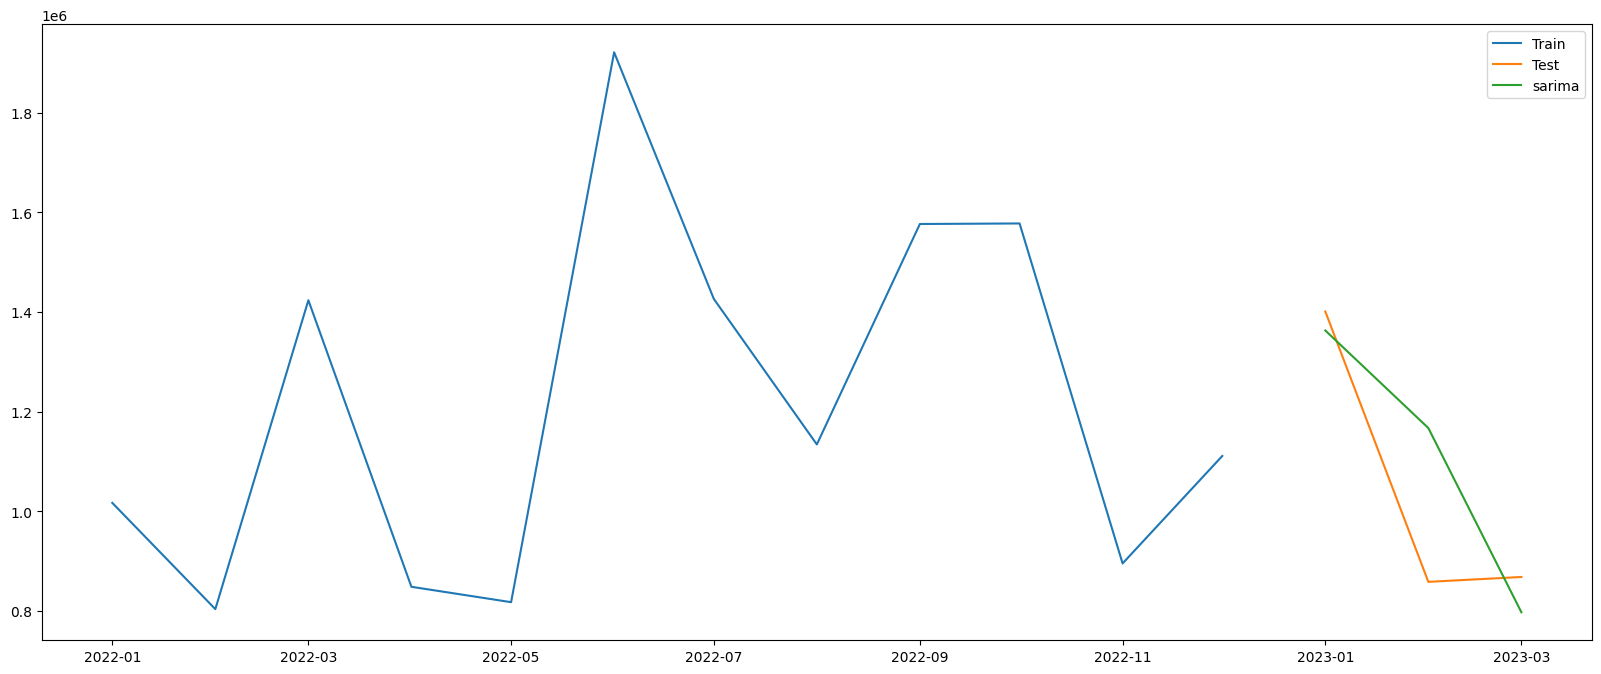

In [82]:
plt.figure(figsize=(20,8))
plt.plot( train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(sar_y_pred_test['quantity_predict'], label='sarima')
plt.legend(loc='best')
plt.show()

In [83]:
# Model Evaluation

print('MAE train = ', mean_absolute_error(train, sar_y_pred_train))
print('MAE test = ', mean_absolute_error(test, sar_y_pred_test))
print(' ')
print('MAPE train :', round(mean_absolute_percentage_error(train, sar_y_pred_train)*100,2))
print('MAPE test :', round(mean_absolute_percentage_error(test, sar_y_pred_test)*100,2))

MAE train =  547518.9283359864
MAE test =  139229.5608029701
 
MAPE train : 44.65
MAPE test : 15.62


Dari hasil evaluasi model SARIMA, Nilai Metric Mae dan Mapenya lebih besar dibandingkan dengan ARIMA. hal ini menunjukan untuk datasetnya tidak terdapt patter seasonal. Sehingga algoritma terbaiknya adalah dengan ARIMA.

## 4.7 - Model Saving

Proses model saving untuk inference data dan deployment.

In [84]:
# Save the Files

import pickle

with open('mod_train.pkl', 'wb') as file_1:
  pickle.dump(mod_train, file_1)


## 4.8 - Inference

Tes dengan data baru

### 4.8.1 - Load saved modeling

In [85]:
# Load All Files

with open('mod_train.pkl', 'rb') as file_1:
  mod_train = pickle.load(file_1)


### 4.8.2  - Create Inference Data

In [86]:
# Create New Data

data_inf = {
    'year' : 2023,
    'month': 5
  }

data_inf = pd.DataFrame([data_inf])
data_inf['date'] = data_inf.apply(lambda x: datetime(x[0], x[1], 1), axis=1)
data_inf.drop(['year','month'], axis=1, inplace=True)
data_inf=data_inf.set_index('date')

### 4.8.3 - Predict Inference Data

In [87]:
#Predict Inference data
y_pred_test=mod_train.predict(start=data_inf.index[0],end=data_inf.index[-1])
y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test.columns=['quantity_predict']
y_pred_test

,quantity_predict
2023-05-01,1.185379e+06


Dari hasil forecast didapatkan hasil untuk bulan 5 maka quantity produk yang terjual untuk produk best_seller sebanyak 1.18 juta produk.

# 5 - Conclusion

Dari hasil proses EDA dapat diketahui dataset tidak ada yang missing value, Dataset tidak memiliki pola tren ataupun seasonal, dan berdasarkan hasil tes adfuller termasuk tidak stasioner. Data penjualan akhir (week_end_date) dimulai dari 2022-01-02 sampai dengan 2023-04-09. 

Dari hasil proses EDA diketahui produk terlaku pada jenis produt_item '2949ca4cfbf13969bccfbb9817f2526a', maka yang dilakukan proses forcasting untuk produk tersebut sesuai dengan objective dan short descriptive title pada bagian introduction. Dari hasil pengamatan untuk best seller secara grafik memiliki kesamaan dengan dengan dataset keseluruhan, yaitu tidak memiliki tren, seasonal, dan tidak stationer kondisinya. Sehingga perlu dilakukan differencing agar bisa dilakukan forecasting dengan time series algoritma ARIMA dan SARIMA.

Setelah dilakukan differencing dilakukan plot ACF dan plot PACF untuk mendapatkan komposisi pada lag berapa cutting off, dan dijadikan parameter order dalam model. Dari hasil model diketahui model yang terbaik dihasilkan dari algoritma ARIMA dengan nilai MAPE 11.76% dan nilai MAE 104.814 Produk. Dari segi model berdasarkan literatur, model ini termasuk baik karena nilai MAPE nya dalam rentang 10-20%. Meskipun tergolong baik, model ini memiliki kelemahan tidak tepat untuk meramal jangak panjang, diatas 6 bulan. Sehingga perlu dilakukan update berkala dengan kondisi real penjualan.

Dari segi bisnis nilai MAE 104.814 adalah kemungkinan lebih besar atau lebih kecil dari nilai prediksi yang dihasilkan model. Seperti dalam hasil tes inference pada bulan ke 5, forecast produk terjual untuk best seller adalah sebesar 1.185.379 produk yang berarti pada realisasinya produk yang terjual berada pada range 1.080.565 hingga 1.290.193 . Dengan mengetahui range tersebut perusahaan bisa memutuskan akan mengambil batas bawah, sesuai prediksi, atau batas atasnya dengan berbagai pertimbangan lainnya.

Untuk improvement dari segi model, bisa dilakukan perbandingan dengan analisis regresi, bukan hanya dengan time series analisis. Untuk mencari nilai metric evaluasi yang terbaik.

Sedangkan untuk business, improvement yang bisa saya sarankan adalah melakukan pendekatan secara kualitatif seperti survei pasar atau konsumen, mencari penyebab kenapa penjualan produknya tidak bisa memiliki tren positif, melainkan naik turun. Sementara untuk jumlah penduduk, khususnya wanita semakin bertambah. Hal ini untuk mencegah terambilnya market share oleh competitor, karena konsumen merasa ada titik jenuh terhadap suatu product ataupun product competitor lebih menarik. 

